## 作業
請試用 LSTM 建立一個模型用以預測感冒在未來的搜尋量？

### 資料讀取

In [1]:
import pandas
df = pandas.read_csv('https://raw.githubusercontent.com/ywchiu/tibamedl/master/Data/cold.csv', parse_dates=['週'])
df.head()

,週,感冒
0,2015-04-12,48
1,2015-04-19,50
2,2015-04-26,45
3,2015-05-03,42
4,2015-05-10,44


In [0]:
df.set_index('週', inplace=True)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36913 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 36913 missing from current font.
  font.set_text(s, 0, flags=flags)


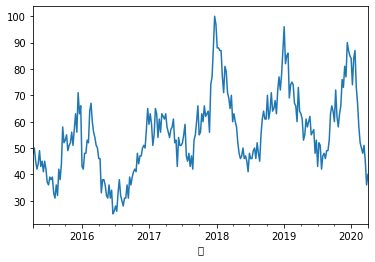

In [3]:
df['感冒'].plot(kind = 'line')

### 訓練與測試資料集切割

In [16]:
len(df)

261

In [0]:
df = df[df.index >= '2015-05-01']

In [24]:
len(df[df.index < '2019-01-01'])

192

In [25]:
df.head()

,感冒
週,
2015-05-03,42
2015-05-10,44
2015-05-17,49
2015-05-24,43
2015-05-31,45


In [0]:
training_set    = df.iloc[0:192, 0:1 ]

In [0]:
test_set    = df.iloc[192:, 0:1 ]

In [34]:
training_set.shape

(192, 1)

In [36]:
test_set.shape

(66, 1)

### 資料標準化

In [0]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [0]:
#training_set_scaled

### 建立資料結構

In [0]:
import numpy as np
X_train = []
y_train = []
for i in range(12, 192):
    X_train.append(training_set_scaled[i-12:i, 0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [39]:
X_train.shape

(180, 12)

In [40]:
y_train.shape

(180,)

In [45]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(180, 12, 1)

### 建立LSTM 模型

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

In [0]:
regressor = tf.keras.models.Sequential()
regressor.add(tf.keras.layers.LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1) ))
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(tf.keras.layers.LSTM(units = 50, return_sequences = True)) 
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(tf.keras.layers.LSTM(units = 50, return_sequences = True)) 
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(tf.keras.layers.LSTM(units = 50))
regressor.add(tf.keras.layers.Dropout(0.2))

regressor.add(tf.keras.layers.Dense(units = 1))

In [48]:
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 12, 50)            10400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 12, 50)            20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 12, 50)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 12, 50)            20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 12, 50)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)               

### 模型訓練

In [51]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 16, verbose = 0)

### 套用到測試資料集

In [0]:
test_set_scaled = sc.transform(test_set)
X_test = []
y_test = []
for i in range(12, 66):
    X_test.append(test_set_scaled[i-12:i, 0])
    y_test.append(test_set_scaled[i,0])

In [0]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [0]:
y_pred = regressor(X_test).numpy().flatten()

In [56]:
y_pred

array([0.5569404 , 0.5374908 , 0.5072737 , 0.47953475, 0.41323817,
       0.38820353, 0.4305881 , 0.44398192, 0.45686612, 0.47722456,
       0.43717518, 0.41383505, 0.41519797, 0.3624548 , 0.35457885,
       0.30324587, 0.3154993 , 0.33808196, 0.29629436, 0.2834766 ,
       0.29451722, 0.2950838 , 0.308834  , 0.3212384 , 0.35192114,
       0.44174328, 0.5194508 , 0.52902997, 0.49163765, 0.5607597 ,
       0.5261329 , 0.4680286 , 0.4750519 , 0.5154155 , 0.62149084,
       0.6359477 , 0.69947207, 0.6806377 , 0.79650104, 0.79344416,
       0.7627996 , 0.7449186 , 0.6477705 , 0.71462595, 0.77862203,
       0.6513462 , 0.5573853 , 0.45825467, 0.37716147, 0.33059758,
       0.30570325, 0.317902  , 0.2984004 , 0.22904062], dtype=float32)

### 繪製預測結果

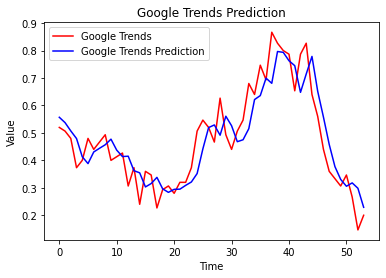

In [57]:
import matplotlib.pyplot as plt
plt.plot(y_test, color = 'red', label = 'Google Trends')
plt.plot(y_pred, color = 'blue', label = 'Google Trends Prediction')
plt.title('Google Trends Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [0]:
y_pred = sc.inverse_transform(y_pred.reshape(-1,1))

In [0]:
y_test = np.array(y_test)
y_test = sc.inverse_transform(y_test.reshape(-1,1))

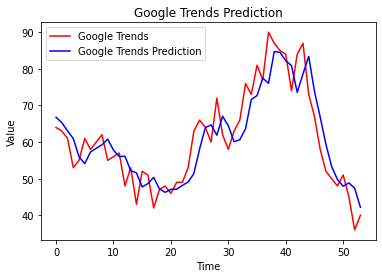

In [62]:
import matplotlib.pyplot as plt
plt.plot(y_test, color = 'red', label = 'Google Trends')
plt.plot(y_pred, color = 'blue', label = 'Google Trends Prediction')
plt.title('Google Trends Prediction')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

## Seq2Seq 模型

In [63]:
from pandas import read_csv
from datetime import datetime

def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')

dataset = read_csv('https://raw.githubusercontent.com/ywchiu/tibamedl/master/Data/pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [64]:
dataset.drop('No', axis=1, inplace=True)
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
dataset['pollution'].fillna(0, inplace=True)
dataset = dataset[24:]
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [0]:
from sklearn.preprocessing import LabelEncoder
values = dataset.values
encoder = LabelEncoder()
wnd_dir = encoder.fit_transform(values[:,4])

In [0]:
dataset['wnd_dir'] = wnd_dir

In [75]:
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,2,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,2,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,2,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,2,6.25,2,0


In [0]:
from sklearn.preprocessing import StandardScaler
def df_to_lstm_format(df, test_size=0.5, look_back=5, target_column='target', scale_X=True):

    df = df.copy()

    # 最後一個欄位為預測目標
    df['target'] = df[target_column] 
    # 捨棄 y
    df = df.drop(columns=[target_column]) 
    
    # 取得目標 y
    target_location = df.shape[1] - 1 
    
    # 根據 test_size 比例分割資料
    split_index = int(df.shape[0]*test_size) 
    
    # 訓練資料集
    X_train = df.values[:split_index, :target_location]
    y_train = df.values[:split_index, target_location]

    # 測試資料集
    X_test = df.values[split_index:, :target_location] 
    y_test = df.values[split_index:, target_location] 

    # 將資料正規化 (如果 scale_X 為True)
    if scale_X:
        scalerX = StandardScaler(with_mean=True, with_std=True).fit(X_train)
        X_train = scalerX.transform(X_train)
        X_test = scalerX.transform(X_test)
        
    # 重塑輸入矩陣
    samples = len(X_train) 
    num_features = target_location 

    samples_train = X_train.shape[0] - look_back
    
    # 重塑訓練資料
    # (資料筆數, 往前看多少筆, 特徵數量)
    X_train_reshaped = np.zeros((samples_train, look_back, num_features))
    y_train_reshaped = np.zeros((samples_train))

    
    for i in range(samples_train):
        y_position = i + look_back
        X_train_reshaped[i] = X_train[i:y_position]
        y_train_reshaped[i] = y_train[y_position]

    # 重塑測試資料
    samples_test = X_test.shape[0] - look_back
    X_test_reshaped = np.zeros((samples_test, look_back, num_features))
    y_test_reshaped = np.zeros((samples_test))

    for i in range(samples_test):
        y_position = i + look_back
        X_test_reshaped[i] = X_test[i:y_position]
        y_test_reshaped[i] = y_test[y_position]
    
    return X_train_reshaped, y_train_reshaped, X_test_reshaped, y_test_reshaped

In [82]:
len(dataset)

43800

In [83]:
dataset.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,2,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,2,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,2,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,2,6.25,2,0


In [0]:
look_back = 24
test_size = 0.5


X_train, y_train, X_test, y_test = df_to_lstm_format(df=dataset, 
                                                     test_size=test_size, 
                                                     look_back=look_back, 
                                                     target_column='pollution', scale_X=True)

In [135]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((21876, 24, 7), (21876,), (21876, 24, 7), (21876,))

### 建立 Seq2Seq 模型 (LSTM)

#### 編碼器 (Encoder)

In [0]:
num_features = dataset.shape[1] - 1

encoder_inputs = tf.keras.layers.Input(shape=(None, num_features))
encoder = tf.keras.layers.LSTM(50, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

#### 解碼器 (Decoder)

In [0]:
decoder_inputs = tf.keras.layers.Input(shape=(None, 1))
decoder_lstm = tf.keras.layers.LSTM(50, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = tf.keras.layers.Dense(1, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

#### 建立且編譯模型

In [0]:
import tensorflow.keras.backend as K
def mape(y_true, y_pred):
    return (K.abs(y_true - y_pred) / K.abs(y_pred)) * 100

def smape(y_true, y_pred):
    return (K.abs(y_pred - y_true) / ((K.abs(y_true) + K.abs(y_pred))))*100

In [0]:
model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='mse', metrics=[mape, smape])

In [140]:
print(model.summary())

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, None, 7)]    0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
lstm_10 (LSTM)                  [(None, 50), (None,  11600       input_12[0][0]                   
__________________________________________________________________________________________________
lstm_11 (LSTM)                  [(None, None, 50), ( 10400       input_13[0][0]                   
                                                                 lstm_10[0][1]              

In [0]:
# 建立編碼器與解碼器所需numpy array
encoder_input_train = X_train
decoder_input_train = np.zeros((X_train.shape[0], X_train.shape[1], 1)) # Zeros array
decoder_output_train = y_train.reshape((y_train.shape[0], 1, 1))

encoder_input_test = X_test
decoder_input_test = np.zeros((X_test.shape[0], X_test.shape[1], 1)) # Zeros array
decoder_output_test = y_test.reshape((y_test.shape[0], 1, 1))

#### 訓練模型

In [143]:
model.fit([encoder_input_train, decoder_input_train], decoder_output_train, 
          validation_data=([encoder_input_test, decoder_input_test], decoder_output_test), 
          epochs=10, verbose=1)



Epoch 1/10
396/684 [================>.............] - ETA: 5s - loss: 8354.6719 - mape: 90.9839 - smape: 34.4955

KeyboardInterrupt: ignored

#### 產生預測結果

In [0]:
encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)

decoder_state_input_h = tf.keras.layers.Input(shape=(50,))
decoder_state_input_c = tf.keras.layers.Input(shape=(50,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = tf.keras.models.Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [0]:
def predict(x, encoder_predict_model, decoder_predict_model, num_steps_to_predict):
    y_predicted = []

    # 將輸入值轉變為狀態向量
    states = encoder_predict_model.predict(x)

    # 狀態向量必須是 list
    if not isinstance(states, list):
        states = [states]

    # 產生第一筆解碼值
    decoder_input = np.zeros((x.shape[0], 1, 1))


    for _ in range(num_steps_to_predict):
        outputs_and_states = decoder_predict_model.predict(
        [decoder_input] + states, batch_size=batch_size)
        output = outputs_and_states[0]
        states = outputs_and_states[1:]

        # 增加預測結果
        y_predicted.append(output)

    return np.concatenate(y_predicted, axis=1)

In [146]:
num_steps_to_predict = 1
batch_size = 1

y_preds= predict(X_test, encoder_model, decoder_model, num_steps_to_predict)
y_preds = y_preds.reshape(y_preds.shape[0])
y_preds.shape

(21876,)

In [147]:
y_preds

array([50.318554, 44.94348 , 40.907516, ..., 14.049082, 14.004002,
       13.962892], dtype=float32)

In [148]:
y_true = y_test.reshape(y_test.shape[0])
y_true.shape

(21876,)

In [0]:
split_index = int(dataset.shape[0]*test_size)
x = dataset[split_index:]

In [150]:

datetime_difference = len(x) - len(y_true)
x = x[datetime_difference:] # 修正延遲數
x.index.shape

(21876,)

684/684 [==============================] - 4s 7ms/step - loss: 8099.2437 - mape: 79.8258 - smape: 32.2419


Text(0.5, 1.0, 'Seq2Seq \n MSE = 8099.24 \n MAPE = 79.8 [%] \n SMAPE = 32.2 [%]')

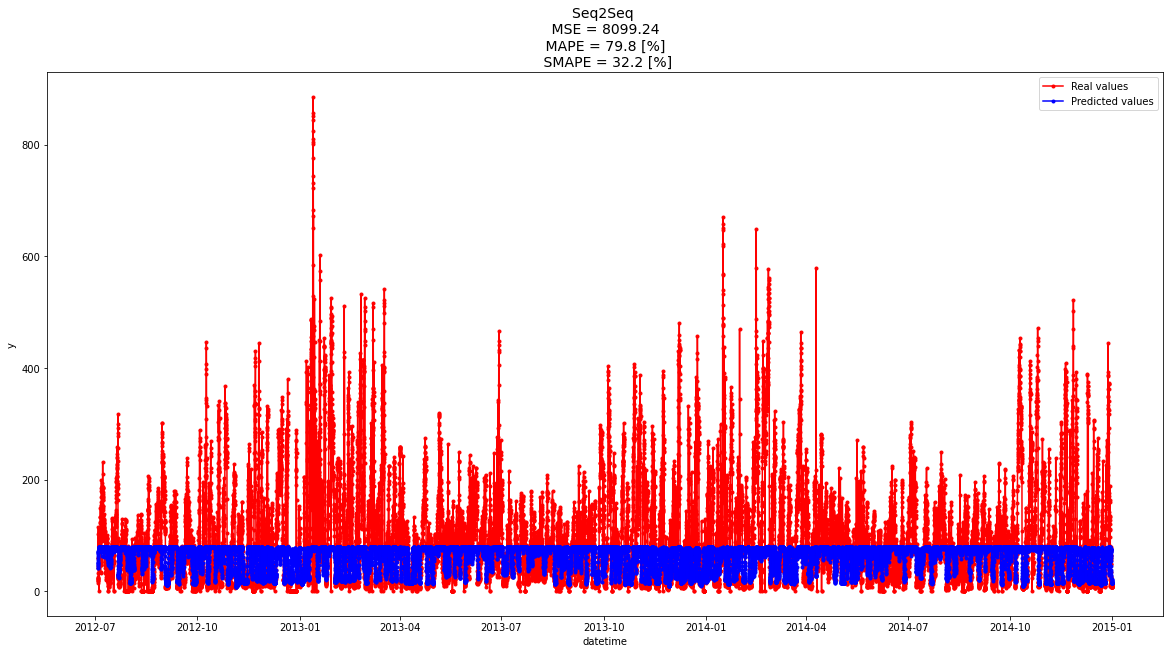

In [151]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(x.index, y_true, '.-', color='red', label='Real values')
plt.plot(x.index, y_preds, '.-', color='blue', label='Predicted values')

plt.ylabel('y')
plt.xlabel('datetime')
plt.legend()

mse = model.evaluate([encoder_input_test, decoder_input_test], decoder_output_test)[0]
mape = model.evaluate([encoder_input_test, decoder_input_test], decoder_output_test)[1]
smape = model.evaluate([encoder_input_test, decoder_input_test], decoder_output_test)[2]

plt.title('Seq2Seq \n MSE = %.2f \n MAPE = %.1f [%%] \n SMAPE = %.1f [%%]' % (mse, mape, smape), fontsize = 14)

## Seq2Seq (GRU版本)
- https://github.com/ywchiu/cathayts/blob/master/Seq2Seq_GRU_Model.ipynb

In [0]:
num_features = dataset.shape[1] - 1
layers = [50,50,]

# 定義輸入序列
encoder_inputs = tf.keras.layers.Input(shape=(None, num_features))


# 建立 Encoder
encoder_cells = []
for hidden_neurons in layers:
    encoder_cells.append(tf.keras.layers.GRUCell(hidden_neurons,
                                              kernel_initializer='TruncatedNormal'))

encoder = tf.keras.layers.RNN(encoder_cells, return_state=True)

encoder_outputs_and_states = encoder(encoder_inputs)

# 只保留狀態，不保留輸出
encoder_states = encoder_outputs_and_states[1:]

In [0]:
output_dim = 1

decoder_inputs = tf.keras.layers.Input(shape=(None, 1))

decoder_cells = []
for hidden_neurons in layers:
    decoder_cells.append(tf.keras.layers.GRUCell(hidden_neurons,
                                             kernel_initializer='TruncatedNormal'))

decoder = tf.keras.layers.RNN(decoder_cells, return_sequences=True, return_state=True)

# 將encoder 的輸出設定為decoder 起始狀態
decoder_outputs_and_states = decoder(decoder_inputs, initial_state=encoder_states)

# 只取得output，不用 state
decoder_outputs = decoder_outputs_and_states[0]

# 產生預測結果
decoder_dense = tf.keras.layers.Dense(output_dim,
                                   activation='linear')

decoder_outputs = decoder_dense(decoder_outputs)

In [0]:
model = tf.keras.models.Model(inputs=[encoder_inputs, decoder_inputs], outputs=decoder_outputs)
model.compile(optimizer='adam', loss='mse', metrics=[mape, smape])

In [156]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, None, 7)]    0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, None, 1)]    0                                            
__________________________________________________________________________________________________
rnn_5 (RNN)                     [(None, 50), (None,  24150       input_16[0][0]                   
__________________________________________________________________________________________________
rnn_6 (RNN)                     [(None, None, 50), ( 23250       input_17[0][0]                   
                                                                 rnn_5[0][1]               